# LPFP algorithm for MFGs with stochastic control

## By Roxana Dumitrescu, Marcos Leutscher and Peter Tankov

See https://arxiv.org/abs/2202.11428

In this notebook we develop the *linear programming fictitious play algorithm* for MFGs with stochastic control (and absorption). 

The MFG problem with stochastic control will be the following: 

i) Fix a flow of subprobability measures $m=(m_t)_{t\in [0, T]}$ on $\bar{\mathcal{O}}\times A$ and a probability measure $\mu$ on $[0, T]\times\bar{\mathcal{O}}$, and find the solution to the stochastic control problem
\begin{equation}
\begin{aligned}
\sup_{\alpha} &  \quad \mathbb{E}\left[\int_{0}^{T\wedge \tau_\mathcal{O}^{\alpha, m}} f\left(t, X^{\alpha, m}_t, m_t, \alpha_t\right) dt + g\left(T\wedge \tau_\mathcal{O}^{\alpha, m}, X^{\alpha,m}_{T\wedge \tau_\mathcal{O}^{\alpha, m}}, \mu\right)\right],\\
\text{s.t. } \quad & dX_{t}^{\alpha, m}=b\left(t, X_{t}^{\alpha, m}, m_t, \alpha_t \right) dt+\sigma\left(t, X_{t}^{\alpha, m}, m_t, \alpha_t \right) dW_{t},\\
& X_0^{\alpha, m} \sim m_0^*,
\end{aligned}
\end{equation}
where $\tau_\mathcal{O}^{\alpha, m}=\inf\{t\geq 0:X_t^{\alpha, m}\notin \mathcal{O}\}$.

ii) Given a solution $\alpha^{m, \mu}$ of the above problem for the agent facing a mean-field $(m, \mu)$, find $m$ such that 
$$m_t=\mathbb P\left((X^{\alpha^{m, \mu}, m}_t, \alpha_t^{m, \mu})\in \cdot, t<T\wedge \tau_\mathcal{O}^{\alpha^{m, \mu}, m}\right)$$
and 
$$\mu =\mathcal{L}\left(T\wedge \tau_\mathcal{O}^{\alpha^{m, \mu}, m}, X_{T\wedge \tau_\mathcal{O}^{\alpha^{m, \mu}, m}}^{\alpha^{m, \mu}, m}\right).$$


The inputs for the algorithm consist in the following data:

- An initial distribution of the players $m_0^*\in \mathcal P(\mathcal{O})$.
- A terminal time $T>0$.
- Functions $b$, $\sigma$, $f$ and $g$.
- Initial guess for the mean field $(\bar\mu^{(0)}, \bar m^{(0)})$.
- Discretrization sets for $[0, T]$, $\bar{\mathcal{O}}$ and $A$.

At iteration $k$, the algorithm computes the best response $(\hat\mu^{(k+1)}, \hat m^{(k+1)})$ for a fixed distribution of the players $(\bar\mu^{(k)}, \bar m^{(k)})$ which influences the dynamics and the rewards. This step can be seen as a single-agent problem in the sense that for fixed $(\bar\mu^{(k)}, \bar m^{(k)})$, one solves a classical stochastic control problem. Therefore, we use linear programming to compute the best response. 

Once the best response is calculated, we update our guess for the mean-field as it is suggested in the fictitious play framekork:
$$(\bar \mu^{(k+1)}, \bar m^{(k+1)}):=\frac{k}{k+1}(\bar \mu^{(k)}, \bar m^{(k)}) + \frac{1}{k+1}(\hat\mu^{(k+1)}, \hat m^{(k+1)}).$$

Note that $\mu$ is supported in the parabolic boundary $\Sigma:=([0, T)\times \partial \mathcal{O})\cup (\{T\}\times \bar{\mathcal{O}})$.

We import the following packages

In [2]:
# Package imports
import numpy as np
import scipy
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from scipy.stats import norm
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from scipy.sparse import hstack

## 1) Best response

We start with the best response algorithm via linear programming.

### Discretization of the time space

We discretize the time space by 
$$t_i=\frac{iT}{n_t}, \quad i\in \{0, 1, \ldots n_t\},$$
where $n_t\in \mathbb N^*$. We denote $\Delta =T/n_t$.

### Discretization of the state space

We assume that $\mathcal{O}=(\underline x, \overline x)$. We discretize the state space with $n_s+1$ points $\underline x = x_0< x_1< \ldots < x_{n_s} = \overline x$, where $n_s\in \mathbb N^*$. We denote
$$\delta_j=x_{j}-x_{j-1}, \quad j\in {1, \ldots, n_s}.$$

We suppose that the points are equally separated with separation $\delta$.

### Discretization of the action space

We discretize the action space with $n_a+1$ points $a_0< a_1< \ldots < a_{n_a}$, where $n_a\in \mathbb N^*$.

### Discretization of the initial distribution

The initial state distribution $m_0^*$ is approximated by convex combinations of dirac masses on the discretization of $\mathcal{O}$. The discretized initial state distribution will be denoted in the code by m0 and it will be a vector of $n_s+1$ components indicating the mass for each $x_j$, $j\in\{0, \ldots, x_{n_s}\}$, but since $m_0^*$ is supported in $\mathcal{O}$, we set the first and last components to $0$.

### Drift, volatility and reward functions

We are given functions $(t, x, a)\mapsto (b, \sigma, f)(t, x, a)$, and $(t, x)\mapsto g(t, x)$. Note that the mean-field term does not appear on the functions since we are treating it as fixed for the best response computation.

### Discretized Generator and test functions

We define
$$Lu(t, x, a)=\frac{\partial u}{\partial t}(t, x) + b(t, x, a)\frac{\partial u}{\partial x}(t, x) + \frac{\sigma^2}{2}(t, x, a)\frac{\partial^2 u}{\partial x^2}(t, x), \quad \forall u\in \mathcal{D}(L):=C^{1, 2}_b([0, T]\times \bar{\mathcal{O}}).$$

We set $\mathcal{D}(\hat L)$ as the functions in $\mathcal{D}(L)=C^{1, 2}_b([0, T]\times \bar{\mathcal{O}})$ restricted to the discretization Time-State. 

We discretize the derivatives for $u\in \mathcal{D}(\hat L)$ as follows: for $i\in\{0, 1, \ldots, n_t-1\}$ and $j\in\{1, \ldots, n_s-1\}$,
$$\hat L_t u (t_i, x_j, a_k)= \frac{1}{\Delta}[u(t_{i+1}, x_j)-u(t_i, x_j)],$$
$$\hat L_x^u u (t_i, x_j, a_k)=\frac{1}{\delta}\max(b(t_i, x_j, a_k), 0)[u(t_{i+1}, x_{j+1})-u(t_{i+1}, x_{j})],$$
$$\hat L_x^d u (t_i, x_j, a_k)=\frac{1}{\delta}\min(b(t_i, x_j, a_k), 0)[u(t_{i+1}, x_{j})-u(t_{i+1}, x_{j-1})],$$
$$\hat L_{xx} u (t_i, x_j, a_k)=\frac{1}{\delta^2}\frac{\sigma^2}{2}(t_i, x_j, a_k)[u(t_{i+1}, x_{j+1}) + u(t_{i+1}, x_{j-1})-2u(t_{i+1}, x_j)].$$
The discretized generator has the form:
$$\hat L u (t_i, x_j, a_k) = \hat L_t u (t_i, x_j, a_k) + \hat L_x^u u (t_i, x_j, a_k) + \hat L_x^d u (t_i, x_j, a_k) + \hat L_{xx} u (t_i, x_j, a_k).$$

The constraint reads as
$$
\sum_{i=0}^{n_t-1}\sum_{j\in\{0, n_s\}} u(t_i, x_j)\hat\mu(t_i, x_j)+ \sum_{j=0}^{n_s} u(t_{n_t}, x_j)\hat\mu(t_{n_t}, x_j) - \Delta \sum_{i=0}^{n_t-1}\sum_{j=1}^{n_s-1}\sum_{k=0}^{n_a} \hat L u(t_i, x_j, a_k) \hat m(t_i, x_j, a_k) = \sum_{j=0}^{n_s}u(t_0, x_j) m_0(x_j), \tag{1}
$$
for $u\in \mathcal{D}(\hat L)$. 

The set $\mathcal{D}(\hat L)$ is equal to the linear span of the indicators functions 
$$\mathbf{1}_{\{(t_i, x_j)\}}, \quad i\in\{0, 1, \ldots, n_t\}, \; j\in\{0, 1, \ldots, n_s\}$$ 
on the Time-State grid. By linearity, it suffices to evaluate the constraint on the set of indicator functions.

Stacking all the indicator functions evaluated in the Time-State grid by rows we get the following matrix:

$$U=
\begin{bmatrix}
u_{1}(t_0, x_0) & \ldots & u_{1}(t_0, x_{n_s}) & \ldots & u_1(t_{n_t}, x_{n_s})\\
\vdots & & & & \vdots\\
u_{n_f}(t_0, x_0) & \ldots & u_{n_f}(t_0, x_{n_s}) & \ldots & u_{n_f}(t_{n_t}, x_{n_s})
\end{bmatrix},
$$
where $n_f$ is the total number of indicator functions. In particular we stack the functions in such a way that $U$ is equal to the indentity matrix. This matrix will be used to define the constraints.

We write the constraint (1) in the following form
$$A_{eq} z = b_{eq},$$
where $A_{eq}$ is a matrix and $z$ and $b_{eq}$ are vectors.

In our case, we will set $z=(z_{mu}, z_m)^T$
$$z_{mu}=[\hat\mu(t_0, x_0), \hat\mu(t_0, x_{n_s}), \hat\mu(t_1, x_0), \hat\mu(t_1, x_{n_s}), \ldots, \hat\mu(t_{n_t}, x_{0}), \hat\mu(t_{n_t}, x_{1}), \hat\mu(t_{n_t}, x_{2}), \ldots, \hat\mu(t_{n_t}, x_{n_s})],$$
$$z_m = [\hat m(t_0, x_1, a_0), \ldots, \hat m(t_0, x_1, a_{n_a}), \hat m(t_0, x_2, a_0), \ldots, \hat m(t_0, x_2, a_{n_a}), \ldots, \hat m(t_{n_t-1}, x_{n_s-1}, a_{n_a}))].$$
We also set $A_{eq}=[A_{eq}^{mu}, A_{eq}^m]$, where
$$A_{eq}^{mu}=
\begin{bmatrix}
u_{1}(t_0, x_0) & u_{1}(t_0, x_{n_s}) & u_{1}(t_1, x_0) & u_{1}(t_1, x_{n_s}) &\ldots & u_{1}(t_{n_t}, x_{0}) & u_{1}(t_{n_t}, x_{1}) & \ldots & u_{1}(t_{n_t}, x_{n_s})\\
\vdots & \vdots & \vdots & \vdots & & \vdots & \vdots & & \vdots\\
u_{n_f}(t_0, x_0) & u_{n_f}(t_0, x_{n_s}) & u_{n_f}(t_1, x_0) & u_{n_f}(t_1, x_{n_s}) &\ldots & u_{n_f}(t_{n_t}, x_{0}) & u_{n_f}(t_{n_t}, x_{1}) & \ldots & u_{n_f}(t_{n_t}, x_{n_s})
\end{bmatrix},
$$
$$A_{eq}^{m}= -\Delta \times
\begin{bmatrix}
\hat L u_{1}(t_0, x_1, a_0) & \ldots & \hat L u_{1}(t_0, x_1, a_{n_a}) & \ldots & \hat L u_{1}(t_{n_t-1}, x_{n_s-1}, a_{n_a})\\
\vdots & & & & \vdots\\
\hat L u_{n_f}(t_0, x_1, a_0) & \ldots & \hat L u_{n_f}(t_0, x_1, a_{n_a}) & \ldots & \hat L u_{n_f}(t_{n_t-1}, x_{n_s-1}, a_{n_a})
\end{bmatrix}.
$$
We define 
$$b_{eq}=[u_1(t_0, \cdot)^Tm_0, \ldots, u_{n_f}(t_0, \cdot)^T m_0]^T.$$

### Reward

The reward is given by
$$
\sum_{i=0}^{n_t-1}\sum_{j\in\{0, n_s\}} g(t_i, x_j)\hat\mu(t_i, x_j)+ \sum_{j=0}^{n_s} g(t_{n_t}, x_j)\hat\mu(t_{n_t}, x_j) + \Delta\times \sum_{i=0}^{n_t-1}\sum_{j=1}^{n_s-1}\sum_{k=0}^{n_a} f(t_i, x_j, a_k) \hat m(t_i, x_j, a_k).
$$

We will minimize the function $c^Tz$ subject to the constraint $A_{eq} z = b_{eq}$, where $c$ is a vector of costs. We will set $c=-(r_{mu}, r_m)^T$, where
$$r_{mu}=[g(t_0, x_0), g(t_0, x_{n_s}), g(t_1, x_0), g(t_1, x_{n_s}) \ldots, g(t_{n_t}, x_{0}), g(t_{n_t}, x_{1}), g(t_{n_t}, x_{2}), \ldots, g(t_{n_t}, x_{n_s})],$$
$$r_m = \Delta \times [f(t_0, x_1, a_0), \ldots, f(t_0, x_1, a_{n_a}), f(t_0, x_2, a_0), \ldots, f(t_0, x_2, a_{n_a}), \ldots, f(t_{n_t-1}, x_{n_s-1}, a_{n_a})].$$

In [3]:
def constraint_generator(Time, State, Action, b, s, Delta, delta, m0, U, Time_mesh_mu, State_mesh_mu, 
                         Time_mesh_m, State_mesh_m, Action_mesh_m):
    """
    Argument:
    Time -- time grid
    State -- state grid
    Action -- action grid
    b -- drift function, it is a function with arguments (t, x, a) of type numpy array, and returning a numpy array   
    s -- volatility function, with same definition as b
    Delta -- time step
    delta -- state step
    m0 -- array for the initial distribution on State
    U -- matrix of test functions valued on the grid
    Time_mesh_mu -- Time in a time-state mesh for mu
    State_mesh_mu -- State in a time-state mesh for mu
    Time_mesh_m -- Time in a time-state-action mesh for m
    State_mesh_m -- State in a time-state-action mesh for m
    Action_mesh_m -- Action in a time-state-action mesh for m
    
    Returns:
    A_eq -- matrix constraint
    b_eq -- column vector constraint
    """
    
    d_t = Time.shape[0]
    d_s = State.shape[0]
    d_a = Action.shape[0]
    d_f = U.shape[0]
    
    B = b(Time_mesh_m, State_mesh_m, Action_mesh_m)
    S = s(Time_mesh_m, State_mesh_m, Action_mesh_m)
    
    C1 = 1/delta * np.maximum(B, 0)
    C2 = 1/delta * np.minimum(B, 0)
    C3 = 1/(delta**2) * S**2/2
    
    A_eq_mu = np.zeros((d_f, 2*(d_t - 1) + d_s))
    #A_eq_m = np.zeros((d_f, (d_t-1) * (d_s-2) * d_a))
    A_eq_m = lil_matrix((d_f, (d_t-1) * (d_s-2) * d_a))
    b_eq = np.zeros((d_f, 1))
    
    for counter in range(d_f):
        V = U[counter, :].reshape((d_t, d_s))
        # mu matrix
        V_1 = V[:-1, [0, -1]].reshape(1,-1)                # t<T, x in boundary
        V_2 = V[-1, :].reshape(1,-1)                       # t=T
        A_eq_mu[counter, :] = np.concatenate((V_1, V_2), axis = 1)
        # m matrix
        V_3 = np.reshape(V, (V.shape[0], V.shape[1], 1))  
        L_t = 1/Delta * (V_3[1:, 1:-1, :]-V_3[:-1, 1:-1, :])
        L_x_u = C1 * (V_3[1:, 2:, :] - V_3[1:, 1:-1, :])
        L_x_d = C2 * (V_3[1:, 1:-1, :] - V_3[1:, :-2, :])
        L_xx = C3 * (V_3[1:, 2:, :] + V_3[1:, :-2, :] - 2 * V_3[1:, 1:-1, :])
        L = L_t + L_x_u + L_x_d + L_xx
        A_eq_m[counter, :] = -Delta * L.reshape(1,-1)
        # b_eq
        b_eq[counter, 0] = np.dot(V[0, :].T, m0)
        
    A_eq_mu = csr_matrix(A_eq_mu)
    A_eq_m = csr_matrix(A_eq_m)
        
    A_eq = hstack((A_eq_mu, A_eq_m))
    A_eq = csr_matrix(A_eq)
    
    return A_eq, b_eq

In [4]:
def cost_generator(Delta, f, g, Time_mesh_mu, State_mesh_mu, Time_mesh_m, State_mesh_m, Action_mesh_m):
    """
    Argument:
    Delta -- time step
    f -- instantaneous reward function, it is a function with arguments (t, x, a) of 
         type numpy array, and returning a numpy array
    g -- terminal reward function, it is a function with arguments (t, x) of 
         type numpy array, and returning a numpy array
    Time_mesh_mu -- Time in a time-state mesh for mu
    State_mesh_mu -- State in a time-state mesh for mu
    Time_mesh_m -- Time in a time-state mesh for m
    State_mesh_m -- State in a time-state mesh for m
    Action_mesh_m -- Action in a time-state-action mesh for m


    Returns:
    c -- cost vector
    """

    G_1 = g(Time_mesh_mu, State_mesh_mu)
    G_2 = G_1[:-1, [0, -1]].reshape(1,-1)                # t<T, x in boundary
    G_3 = G_1[-1, :].reshape(1,-1)                       # t=T
    r_mu = np.concatenate((G_2, G_3), axis = 1) 
                 
    F = f(Time_mesh_m, State_mesh_m, Action_mesh_m)
    r_m = Delta * F.reshape(1,-1)

    
    ## Attention with the minus sign, since the linear program is for costs instead of rewards                   
    c = - np.concatenate((r_mu.T, r_m.T), axis=0)
    
    return c

### Interior point algorithm

We give two different ways to solve the LP problem with python. The first one is based on scipy's linprog function and the second one uses Gurobi's LP solver (a free academic license is available). In order to make the code more readable, we set $\hat\mu(t_i, x_j)=0$ for $(t_i, x_j)\notin \Sigma$ so that $\hat\mu$ is a probability measure on $[0, T]\times \bar{\mathcal{O}}$ supported on $\Sigma$.

In [5]:
# Scipy linprog

def best_response(Time, State, Action, A_eq, b_eq, c):
    """
    Argument: 
    Time -- time grid
    State -- state grid
    Action -- action grid
    A_eq -- matrix constraint
    b_eq -- column vector constraint
    c -- cost vector
    
    Returns:
    value -- maximal value
    mu_sol -- 2-array with mu valued in the grid Time-State
    m_sol -- 3-array with m valued in the grid Time-State-Action
    """
    
    d_t = Time.shape[0]
    d_s = State.shape[0]
    d_a = Action.shape[0]

    res = linprog(c, A_eq = A_eq, b_eq = b_eq, method ='interior-point',
                  options = {"sparse": True, 'rr':False, 'permc_spec':'COLAMD'})
                
    z = res.x
    
    z_mu = z[:(2*(d_t - 1) + d_s)]
    z_m = z[(2*(d_t - 1) + d_s):]
    
    z_mu_1 = z_mu[:2*(d_t - 1)].reshape((d_t - 1, 2))   # t<T, x in boundary
    z_mu_2 = z_mu[2*(d_t - 1):].reshape((1, d_s))      # t=T
    
    mu_sol = np.zeros((d_t, d_s))
    mu_sol[:-1, [0, -1]] = z_mu_1
    mu_sol[-1, :] = z_mu_2

    m_sol = z_m.reshape((d_t-1, d_s-2, d_a))
    
    value = - res.fun # - min -h = max h
    
    return value, mu_sol, m_sol

In order to accelarate the computations, one can use the Gurobi solver. In that case do not use the previous function "best_response", but the following one. 

In [6]:
import gurobipy as gp
from gurobipy import GRB

In [7]:
# Gurobi

def best_response(Time, State, Action, A_eq, b_eq, c):
    """
    Argument: 
    Time -- time grid
    State -- state grid
    Action -- action grid
    A_eq -- matrix constraint
    b_eq -- column vector constraint
    c -- cost vector
    
    Returns:
    value -- maximal value
    mu_sol -- 2-array with mu valued in the grid Time-State
    m_sol -- 2-array with m valued in the grid Time-State
    """
    
    #A_eq = csr_matrix(A_eq)
    
    reward = -c
    
    model = gp.Model()
    model.Params.LogToConsole = 0
    rows, cols = len(b_eq), len(reward)
    variables = []
    for j in range(cols):
        variables.append(model.addVar(lb=0, ub=1, obj=reward[j, 0]))
    model.update()
    
    # iterate over the rows of A_eq adding each row into the model
    for i in range(rows):
        start = A_eq.indptr[i]
        end = A_eq.indptr[i+1]
        variables_row = [variables[j] for j in A_eq.indices[start:end]]
        coeff = A_eq.data[start:end]
        expr = gp.LinExpr(coeff, variables_row)
        model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=b_eq[i, 0])
    
    model.update()
    model.ModelSense = -1
    model.optimize()
    
    d_t = Time.shape[0]
    d_s = State.shape[0]
    d_a = Action.shape[0]
    
    z = np.array([variables[j].X for j in range(cols)])
    
    z_mu = z[:(2*(d_t - 1) + d_s)]
    z_m = z[(2*(d_t - 1) + d_s):]
    
    z_mu_1 = z_mu[:2*(d_t - 1)].reshape((d_t - 1, 2))   # t<T, x in boundary
    z_mu_2 = z_mu[2*(d_t - 1):].reshape((1, d_s))      # t=T
    
    mu_sol = np.zeros((d_t, d_s))
    mu_sol[:-1, [0, -1]] = z_mu_1
    mu_sol[-1, :] = z_mu_2

    m_sol = z_m.reshape((d_t-1, d_s-2, d_a))
                        
    return model.ObjVal, mu_sol, m_sol

## 2) Fictitious Play iteration

Here we present the Fictitious Play iteration of the best responses approximating the LP MFG Nash equilibrium. If the coefficients $b$ and $\sigma$ do not depend on the measure, the matrix of the constraint is computed only once. Moreover, we give two possibilities to track the convergence of the algorithm. The first one is the exploitability (which can be used when $b$ and $\sigma$ do not depend on the measure):
$$\varepsilon(\bar\mu, \bar m):=\sup_{(\mu, m)}\langle m-\bar m, f[\bar m]\rangle + \langle \mu-\bar \mu, g[\bar \mu]\rangle,$$
where the supremum is taken over the measures satisfying the constraint. The second one is a distance between the measures:
$$d((\mu, m),(\bar\mu, \bar m)):=\max\left\{\Delta \sum_{i, j, k}|m(t_i, x_j, a_k) - \bar m(t_i, x_j, a_k)|, \sum_{i, j}|\mu(t_i, x_j) - \bar \mu(t_i, x_j)|\right\}.$$

In [8]:
def fictitious_play(Time, State, Action, b_factory, s_factory, Delta, delta,
                    m0, f_factory, g_factory, tol, N_iter, mu_tilde_0, m_tilde_0, coeff_dep, error):
    """
    Argument:
    Time -- time grid
    State -- state grid
    Action -- action grid
    b_factory -- mean field functional for b  
    s_factory -- mean field functional for sigma 
    Delta -- time step
    delta -- state step
    m0 -- array for the initial distribution on State
    f_factory -- mean field functional for f
    g_factory -- mean field functional for g  
    tol -- error tolerance
    N_iter -- maximum number of iterations
    mu_tilde_0 -- preliminary guess for mu
    m_tilde_0 -- preliminary guess for m
    coeff_dep -- True if the coefficients b or sigma depend on the measure, False if they do not
    error -- string. Choose between 'exploitability' and 'dist'. When the coefficients b or sigma depend on the measure
             use 'dist'
    
    Returns:
    value -- approximate Nash value
    mu_bar -- 2-array with mu valued in the grid Time-State
    m_bar -- 2-array with m valued in the grid Time-State-Action
    mu_hat -- 2-array with mu valued in the grid Time-State
    m_hat -- 2-array with m valued in the grid Time-State-Action
    eps_array -- 1-array with the errors
    """
    
    U = np.identity((Time.shape[0] * State.shape[0]))
    
    # Mesh grids: we will use the following meshgrids for mu and m

    Time_mesh_mu, State_mesh_mu = np.meshgrid(Time[:, 0], State[:, 0], indexing='ij') 
    Time_mesh_m, State_mesh_m, Action_mesh_m = np.meshgrid(Time[:-1, 0], State[1:-1, 0], Action[:, 0], indexing='ij')
    
    State_mesh_m_1, Action_mesh_m_1 = np.meshgrid(State[1:-1, 0], Action[:, 0], indexing='ij') 
    
    # The preliminary guess mu_tilde_0, m_tilde_0 does not satisfy necessarily the constraint, henceforth we get the initial
    # guess by computing the best response to the preliminary guess
    
    m_bar = m_tilde_0
    mu_bar = mu_tilde_0
    
    # The functions b_factory, s_factory, etc are defined later
    
    b_n = b_factory(m_bar, State_mesh_m_1, Action_mesh_m_1)
    s_n = s_factory(m_bar, State_mesh_m_1, Action_mesh_m_1)
    f_n = f_factory(m_bar, State_mesh_m_1, Action_mesh_m_1)
    g_n = g_factory(mu_bar, Time_mesh_mu, State_mesh_mu)
    
    A_eq, b_eq = constraint_generator(Time, State, Action, b_n, s_n, Delta, delta, m0, U, 
                                      Time_mesh_mu, State_mesh_mu, Time_mesh_m, State_mesh_m, Action_mesh_m)
    
    c = cost_generator(Delta, f_n, g_n, Time_mesh_mu, State_mesh_mu, Time_mesh_m, State_mesh_m, Action_mesh_m)
    
    value, mu_hat, m_hat = best_response(Time, State, Action, A_eq, b_eq, c)
        
    m_bar = m_hat
    mu_bar = mu_hat
    
    n = 1
    
    eps = tol + 1 
    
    eps_list = []
    
    message = "Iteration: {:4d}; Error:  {:.7f}"
    
    while (eps > tol) and (n <= N_iter):
        
        if coeff_dep == True:
            
            b_n = b_factory(m_bar, State_mesh_m_1, Action_mesh_m_1)
            s_n = s_factory(m_bar, State_mesh_m_1, Action_mesh_m_1)
            A_eq, b_eq = constraint_generator(Time, State, Action, b_n, s_n, Delta, delta, m0, U, 
                                              Time_mesh_mu, State_mesh_mu, Time_mesh_m, State_mesh_m, Action_mesh_m)
            
        f_n = f_factory(m_bar, State_mesh_m_1, Action_mesh_m_1)
        g_n = g_factory(mu_bar, Time_mesh_mu, State_mesh_mu)
    
        c = cost_generator(Delta, f_n, g_n, Time_mesh_mu, State_mesh_mu, Time_mesh_m, State_mesh_m, Action_mesh_m)        
        
        value, mu_hat, m_hat = best_response(Time, State, Action, A_eq, b_eq, c)
        
        # Error
        if error == 'exploitability':
            
            eps = Delta*np.sum(f_n(Time_mesh_m, State_mesh_m, Action_mesh_m) * (m_hat - m_bar)) + \
                  np.sum(g_n(Time_mesh_mu, State_mesh_mu) * (mu_hat - mu_bar))
        else:
            
            eps = np.maximum(Delta*np.sum(np.abs(m_hat - m_bar)), np.sum(np.abs(mu_hat - mu_bar)))
        
        
        eps_list.append(eps)
        
        mu_bar = n/(n+1)*mu_bar + 1/(n+1)*mu_hat
        m_bar = n/(n+1)*m_bar + 1/(n+1)*m_hat
        
        print(message.format(n, eps))
        
        n += 1

    eps_array = np.array(eps_list)
        
    return value, mu_bar, m_bar, mu_hat, m_hat, eps_array

## 3) Example

We give an example of MFG with stochastic control and approximate the equilibrium via the LPFP algorithm.

We define the Time space, State space, Action space and the intial distribution of the players. The numbers $\delta$ and $\Delta$ should satisfy:
$$\Delta\leq \frac{\delta^2}{\sigma^2(t_i, x_j, a_k) + \delta |b|(t_i, x_j, a_k)}, \quad \forall (i, j, k).$$

In [9]:
#Initial data
T = 1.0

n_t=500
n_s=70
n_a=20

# Time space
Time = np.linspace(0, T, num = n_t + 1)
Time = np.reshape(Time, (Time.shape[0], 1))

Delta = Time[1, 0] - Time[0, 0]

# State space
State = np.linspace(-2, 2, num = n_s + 1)
State = np.reshape(State, (State.shape[0], 1))

delta = State[1, 0] - State[0, 0]

# Action space  
Action = np.linspace(-1., 1., num = n_a + 1)
Action = np.reshape(Action, (Action.shape[0], 1))

# Initial distribution
norm_0 = norm.pdf(State[1:-1, 0], np.mean(State), 0.1**(1/2))
norm_0 = np.insert(norm_0, 0, 0.)
norm_0 = np.insert(norm_0, len(norm_0), 0.)
m0 = np.reshape(norm_0, (norm_0.shape[0], 1))
m0 = m0/np.sum(m0)

# Mesh grids: we will usually use the following meshgrids for mu and m

Time_mesh_mu, State_mesh_mu = np.meshgrid(Time[:, 0], State[:, 0], indexing='ij') 
Time_mesh_m, State_mesh_m, Action_mesh_m = np.meshgrid(Time[:-1, 0], State[1:-1, 0], Action[:, 0], indexing='ij') 

In [10]:
(1+delta)/delta**2

323.7499999999998

We are going to define a preliminary guess $(\tilde \mu^{(0)}, \tilde m^{(0)})$ for the equilibrium. We start by creating $\tilde\mu^{(0)}$ which has to be a probability measure on the discretization of the parabolic boundary $\Sigma$.

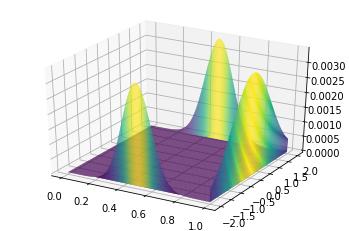

In [11]:
mu_tilde_0 = np.zeros((Time.shape[0], State.shape[0]))
mu_tilde_0[:-1, 0] = norm.pdf(Time[:-1, 0], np.mean(Time[:-1, 0]), 0.01**(1/2))
mu_tilde_0[:-1, -1] = norm.pdf(Time[:-1, 0], np.mean(Time[:-1, 0]), 0.01**(1/2))
mu_tilde_0[-1, :] = 10*norm.pdf(State[:, 0], np.mean(State[:, 0]), 1**(1/2))

mu_tilde_0 = mu_tilde_0/np.sum(mu_tilde_0)

ax = plt.axes(projection='3d')
ax.plot_surface(Time_mesh_mu, State_mesh_mu, mu_tilde_0, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
plt.show()

Now we create the guess $\tilde m^{(0)}$: for each $t$ in the discretization of $[0, T[$, $\tilde m^{(0)}_t$ has to be a subprobability on the discretization of $\mathcal{O}\times A$.

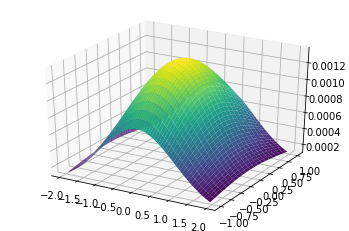

In [12]:
normal_1 = norm.pdf(State[1:-1, 0], np.mean(State[1:-1, 0]), 1**(1/2))
normal_2 = norm.pdf(Action[:, 0], np.mean(Action[:, 0]), 1**(1/2))

Time_m_0, State_m_0, Action_m_0 = np.meshgrid(Time[:-1,0], normal_1, normal_2, indexing='ij') 

m_tilde_0 = State_m_0 * Action_m_0
sum_0 = np.sum(m_tilde_0, axis=(1, 2))
sum_0 = np.reshape(sum_0, (sum_0.shape[0], 1, 1))
m_tilde_0 = m_tilde_0 / sum_0

State_mesh_m_1, Action_mesh_m_1 = np.meshgrid(State[1:-1,0], Action[:, 0], indexing='ij') 

ax = plt.axes(projection='3d')
ax.plot_surface(State_mesh_m_1, Action_mesh_m_1, m_tilde_0[0, :, :], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
plt.show()

Since in each iteration the mean field term will be fixed, we want to define the functions $b$, $\sigma$, $f$ and $g$ as functionals associating to each mean field term a function.

In [13]:
def b_factory(m, y, u):
    """
    Argument:
    m -- 3-array mean field term of size Time-State-Action
    y, u -- meshgrid. Auxiliary variable to compute the integrals with respect to m
    
    Returns:
    b -- drift associated to m
    """
    def b(t, x, a):
        """
        Argument:
        t -- Float. Time variable.
        x -- Float. State variable.
        a -- Float. Action variable.
        
        Returns:
        b[m](t, x, a) -- Float.
        """
        i= np.where(Time[:-1, 0] == t)[0][0]
        m_t = m[i, :, :]
        return a
    return np.vectorize(b)

def s_factory(m, y, u):
    """
    Argument:
    m -- 3-array mean field term of size Time-State-Action
    y, u -- meshgrid. Auxiliary variable to compute the integrals with respect to m
    
    Returns:
    s -- volatility associated to m
    """
    def s(t, x, a):
        """
        Argument:
        t -- Float. Time variable.
        x -- Float. State variable.
        a -- Float. Action variable.
        
        Returns:
        s[m](t, x, a) -- Float.
        """
        i= np.where(Time[:-1, 0] == t)[0][0]
        m_t = m[i, :, :]
        return 1
    return np.vectorize(s)

def f_factory(m, y, u):
    """
    Argument:
    m -- 3-array mean field term of size Time-State-Action
    y, u -- meshgrid. Auxiliary variable to compute the integrals with respect to m
    
    Returns:
    f -- instantaneous reward associated to m
    """

    def f(t, x, a): 
        """
        Argument:
        t -- Float. Time variable.
        x -- Float. State variable.
        a -- Float. Action variable.
        
        Returns:
        f[m](t, x, a) -- Float.
        """
        i= np.where(Time[:-1, 0] == t)[0][0]
        m_t = m[i, :, :]
        mean = np.sum(np.exp(-np.abs(x-y))*m_t)
        return - 10*mean - 2*np.abs(np.abs(x)-1)-a**2
    return np.vectorize(f)


def g_factory(mu, s, y):
    """
    Argument:
    mu -- 2-array mean field term of size Time-State
    s, y -- Meshgrid. Auxiliary time variable to compute the integrals with respect to mu
    
    Returns:
    g -- final reward associated to mu
    """
    def g(t, x):
        """
        Argument:
        t -- Float. Time variable.
        x -- Float. State variable.
        
        Returns:
        g[mu](t, x) -- Float.
        """
        return -np.abs(x)
    return np.vectorize(g)

## 4) Results

We collect the results and visualize them on plots. 

In [14]:
%%time 

tol = 10**(-9)             # the iterations stop when error < tol
N_iter = 100               # the iterations stop when they reach N_iter
coeff_dep = False          # True if b or sigma depend on the measure, False otherwise
error = 'exploitability'   # Choose between 'exploitability' and 'dist'. When the coefficients b or sigma depend on the measure
                           # use 'dist'.

value, mu_bar, m_bar, mu_hat, m_hat, eps = fictitious_play(Time, State, Action,
                                       b_factory, s_factory, Delta, delta, m0, f_factory, g_factory,
                                       tol, N_iter, mu_tilde_0, m_tilde_0, coeff_dep, error)

Set parameter TokenServer to value "PYGMALION"
Iteration:    1; Error:  0.0028010
Iteration:    2; Error:  0.0012685
Iteration:    3; Error:  0.0008225
Iteration:    4; Error:  0.0006112
Iteration:    5; Error:  0.0004853
Iteration:    6; Error:  0.0004034
Iteration:    7; Error:  0.0003445
Iteration:    8; Error:  0.0003012
Iteration:    9; Error:  0.0002671
Iteration:   10; Error:  0.0002403
Iteration:   11; Error:  0.0002181
Iteration:   12; Error:  0.0002000
Iteration:   13; Error:  0.0001843
Iteration:   14; Error:  0.0001712
Iteration:   15; Error:  0.0001596
Iteration:   16; Error:  0.0001497
Iteration:   17; Error:  0.0001407
Iteration:   18; Error:  0.0001330
Iteration:   19; Error:  0.0001259
Iteration:   20; Error:  0.0001196
Iteration:   21; Error:  0.0001138
Iteration:   22; Error:  0.0001087
Iteration:   23; Error:  0.0001039
Iteration:   24; Error:  0.0000996
Iteration:   25; Error:  0.0000956
Iteration:   26; Error:  0.0000919
Iteration:   27; Error:  0.0000885
Iteratio

In [15]:
np.save('mu_bar', mu_bar)
np.save('m_bar', m_bar)
np.save('eps', eps)

In [ ]:
mu_bar = np.load('mu_bar.npy')
m_bar = np.load('m_bar.npy')
eps = np.load('eps.npy')

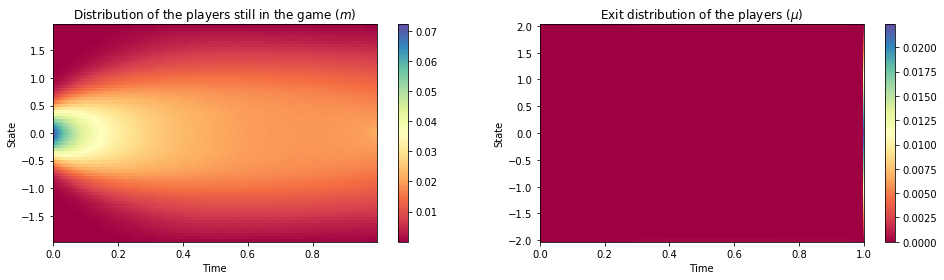

In [19]:
x_m, y_m = np.meshgrid(Time[:, 0]-Delta/2, State[1:, 0]-delta/2, indexing='ij') # Depends on the version of matplotlib
x_mu = np.append(Time[:, 0], Time[-1, 0]+Delta)-Delta/2
y_mu = np.append(State[:, 0], State[-1, 0]+delta)-delta/2
x_mu, y_mu = np.meshgrid(x_mu, y_mu, indexing='ij') 

fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(1, 2, 1)  
ax2 = fig.add_subplot(1, 2, 2)

m_tx = np.sum(m_bar, axis = 2)

c1 = ax1.pcolormesh(x_m, y_m, m_tx, cmap='Spectral', vmin = m_tx.min(),
                    vmax = m_tx.max())

ax1.set_xlabel("Time")                     
ax1.set_ylabel("State")                     
ax1.set_title("Distribution of the players still in the game ($m$)")

fig.colorbar(c1, ax = ax1)

c2 = ax2.pcolormesh(x_mu, y_mu, mu_bar, cmap='Spectral',  vmin = mu_bar.min(),
                    vmax = mu_bar.max())

ax2.set_xlabel("Time")                     
ax2.set_ylabel("State")                     
ax2.set_title("Exit distribution of the players ($\mu$)")

fig.colorbar(c2, ax = ax2);

The randomized control is defined as a probability on the discretization of $A$ for each $(t_i, x_j)$. More precisely given a discrete flow of subprobabilties $m$, we define
$$\nu_{t_i, x_j}(a_k):= \frac{m(t_i, x_j, a_k)}{\sum_k m(t_i, x_j, a_k)},$$
when $\sum_k m(t_i, x_j, a_k)>0$, and as $\delta_{a_0}$ otherwise. 

In the next plot, we represent the average control mapping
$$(t_i, x_j)\mapsto \sum_{k}a_k\nu_{t_i, x_j}(a_k).$$

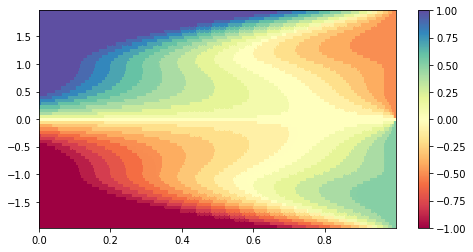

In [20]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1)
        
control = np.sum(Action_mesh_m*m_bar, axis =2)/m_tx

c = ax.pcolormesh(x_m, y_m, control, cmap='Spectral', vmin=control.min(),
                          vmax=control.max())

fig.colorbar(c, ax=ax);

We can also compute the proportion of players still in the game for each time.

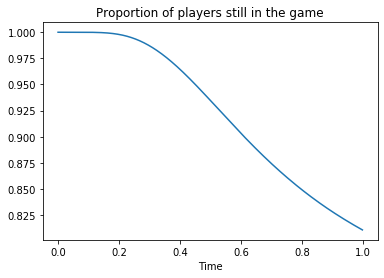

In [21]:
prop = np.sum(m_tx, axis=1)
plt.plot(Time[:-1, 0], prop)
plt.xlabel("Time")
plt.title("Proportion of players still in the game");

We can track the convergence of the algorithm via the exploitability.

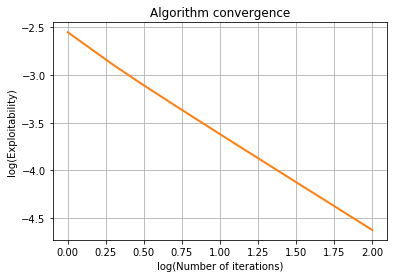

In [22]:
plt.plot(np.log10(np.arange(len(eps))+1), np.log10(eps), 'tab:orange', linewidth=2)
plt.title('Algorithm convergence')
plt.xlabel('log(Number of iterations)')
plt.ylabel('log(Exploitability)')
plt.grid();

We can also visualize the results as in the following plot.

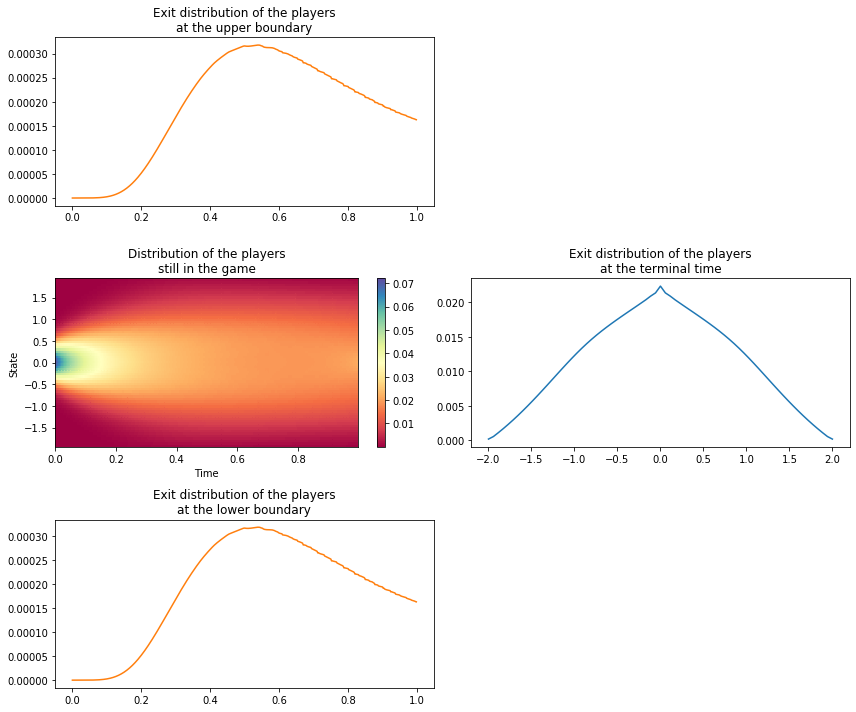

In [23]:
Time_mesh_m_new, State_mesh_m_new = np.meshgrid(Time[:-1, 0], State[1:-1, 0], indexing='ij') 
m_tx = np.sum(m_bar, axis = 2)
    

fig, ax = plt.subplots(3, 2, figsize=(12,10))

ax[0, 0].plot(Time[:-1], mu_bar[:-1, -1], 'tab:orange')
ax[0, 0].set_title('Exit distribution of the players' 
                   "\n" 
                   'at the upper boundary')

ax[0, 1].axis('off')

c = ax[1, 0].pcolormesh(Time_mesh_m_new, State_mesh_m_new, m_tx, cmap='Spectral', vmin=m_tx.min(),
                          vmax=m_tx.max(), shading='nearest')

fig.colorbar(c, ax=ax[1, 0])
ax[1, 0].set_title('Distribution of the players' 
                   "\n" 
                   'still in the game')
ax[1, 0].set(xlabel='Time', ylabel='State')


ax[1, 1].plot(State, mu_bar[-1, :], 'tab:blue')

ax[1, 1].set_title('Exit distribution of the players' 
                   "\n" 
                   'at the terminal time')

ax[2, 0].plot(Time[:-1], mu_bar[:-1, 0], 'tab:orange')

ax[2, 0].set_title('Exit distribution of the players' 
                   "\n" 
                   'at the lower boundary')

ax[2, 1].axis('off')

fig.tight_layout()

plt.show()